In [ ]:
/workspace/slice-monorepo/thebeast/combined

In [ ]:
!pip install -q scikit-learn tensorflow transformers matplotlib

Epoch 1/50000 | Data size: 10.5 | Train Loss: 10.3366 | Val Loss: 10.3005 | Train Acc: 0.00% | Val Acc: 0.00%
Epoch 2/50000 | Data size: 11.025 | Train Loss: 10.2235 | Val Loss: 10.2640 | Train Acc: 3.17% | Val Acc: 2.34%
Epoch 3/50000 | Data size: 11.57625 | Train Loss: 10.1531 | Val Loss: 10.1476 | Train Acc: 10.29% | Val Acc: 6.05%
Epoch 4/50000 | Data size: 12.1550625 | Train Loss: 10.0786 | Val Loss: 10.0892 | Train Acc: 10.57% | Val Acc: 7.03%
Epoch 5/50000 | Data size: 12.762815625 | Train Loss: 10.0516 | Val Loss: 9.8832 | Train Acc: 8.73% | Val Acc: 16.50%
Epoch 6/50000 | Data size: 13.40095640625 | Train Loss: 9.9734 | Val Loss: 9.9241 | Train Acc: 10.59% | Val Acc: 12.30%
Epoch 7/50000 | Data size: 14.0710042265625 | Train Loss: 9.9274 | Val Loss: 9.7909 | Train Acc: 11.74% | Val Acc: 12.79%
Epoch 8/50000 | Data size: 14.774554437890625 | Train Loss: 9.8935 | Val Loss: 9.6548 | Train Acc: 11.17% | Val Acc: 21.39%
Epoch 9/50000 | Data size: 15.513282159785156 | Train Loss: 9.

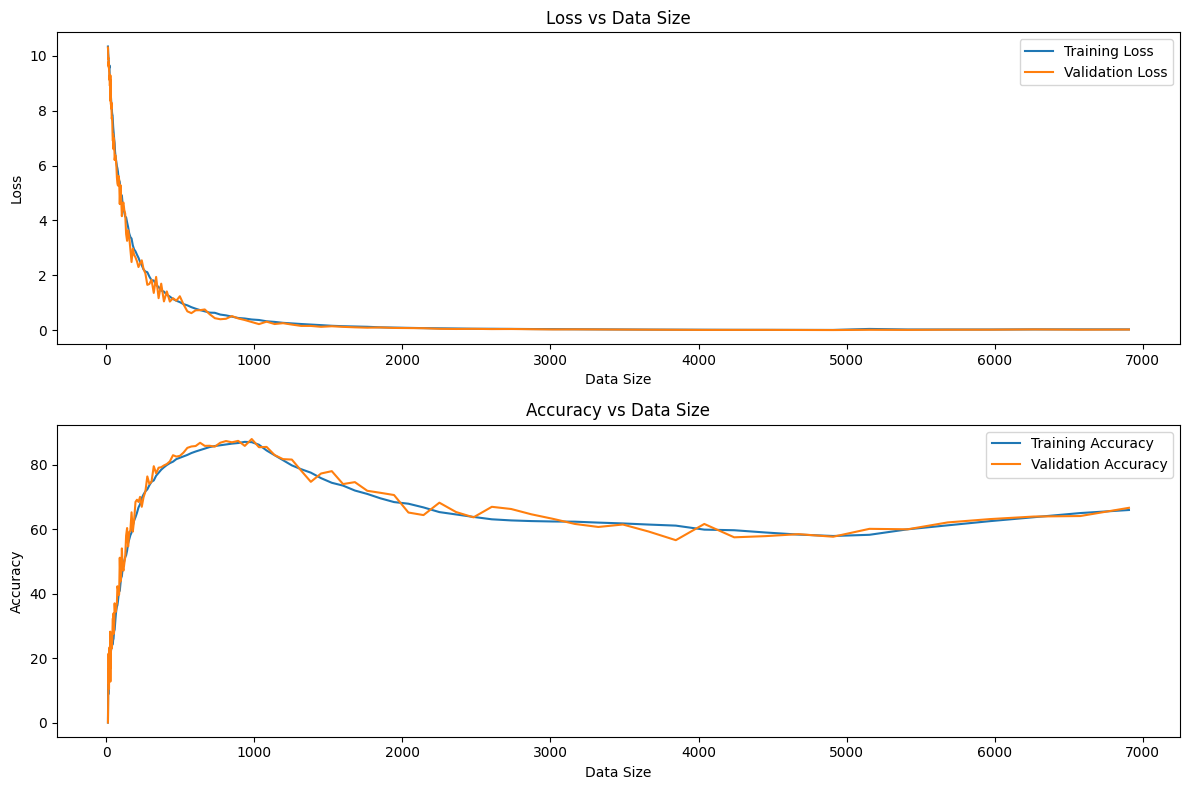

Original: as a time traveler visiting earth in the year 3000, the most surprising change i notice is in the realm of technology, specifically the advent and integration of quantum computing and artificial intelligence ( ai ) into everyday life. this technological leap has fundamentally transformed society in ways that are both awe - inspiring and complex. # # # quantum computing and ai integration # # # # description : quantum computers, which leverage the principles of quantum mechanics, have become ubiquitous. these machines are capable of processing information at speeds and scales unimaginable in the 21st century. coupled with advanced ai, they have revolutionized everything from healthcare to transportation, and even the way humans interact with each other and their environment. # # # # impact on society : 1. * * healthcare : * * - * * personalized medicine : * * quantum computing has enabled the analysis of vast amounts of genetic data, leading to highly personalized medical trea

In [2]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt

# Load data from JSON files in the specified folder
def load_data(folder_path):
    texts = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            with open(os.path.join(folder_path, file_name), 'r') as file:
                data = json.load(file)
                if isinstance(data, dict) and 'response_content' in data:
                    texts.append(data['response_content'])
                elif isinstance(data, list):
                    for item in data:
                        if 'response_content' in item:
                            texts.append(item['response_content'])
    return texts

# Preprocess text data using a tokenizer
def preprocess_texts(texts, tokenizer, max_length=512):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
    return encodings.input_ids, encodings.attention_mask

# Define the Autoencoder model using a pretrained BERT model as the encoder
class BertAutoencoder(nn.Module):
    def __init__(self, bert_model_name, lstm_units=256, max_length=512):
        super(BertAutoencoder, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.encoder = self.bert.encoder
        self.decoder = nn.LSTM(self.bert.config.hidden_size, lstm_units, batch_first=True)
        self.output_layer = nn.Linear(lstm_units, self.bert.config.vocab_size)
        self.max_length = max_length

    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        encoder_outputs = bert_outputs.last_hidden_state
        decoder_outputs, _ = self.decoder(encoder_outputs)
        output = self.output_layer(decoder_outputs)
        return output

# Progressive data increment method
def progressive_training(model, data, attention_masks, tokenizer, initial_size, increment_ratio, max_epochs, device):
    current_size = initial_size
    total_size = len(data)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    metrics = []

    for epoch in range(max_epochs):
        if current_size > total_size:
            break
        current_data = data[:int(current_size)]
        current_masks = attention_masks[:int(current_size)]
        x_train, x_test, y_train, y_test, mask_train, mask_test = train_test_split(current_data, current_data, current_masks, test_size=0.1)

        train_dataset = TensorDataset(x_train, y_train, mask_train)
        test_dataset = TensorDataset(x_test, y_test, mask_test)

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

        model.train()
        train_loss, correct, total = 0, 0, 0
        for inputs, targets, masks in train_loader:
            inputs, targets, masks = inputs.to(device), targets.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, masks)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(2)
            total += targets.size(0) * targets.size(1)
            correct += predicted.eq(targets).sum().item()

        train_accuracy = 100. * correct / total

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, targets, masks in test_loader:
                inputs, targets, masks = inputs.to(device), targets.to(device), masks.to(device)
                outputs = model(inputs, masks)
                loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
                val_loss += loss.item()
                _, predicted = outputs.max(2)
                total += targets.size(0) * targets.size(1)
                correct += predicted.eq(targets).sum().item()

        val_accuracy = 100. * correct / total
        metrics.append((current_size, train_loss/len(train_loader), val_loss/len(test_loader), train_accuracy, val_accuracy))
        current_size += current_size * increment_ratio

        print(f'Epoch {epoch+1}/{max_epochs} | Data size: {current_size} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(test_loader):.4f} | Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%')
    
    return metrics

# Plotting function
def plot_metrics(metrics):
    sizes, train_losses, val_losses, train_accuracies, val_accuracies = zip(*metrics)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(sizes, train_losses, label='Training Loss')
    plt.plot(sizes, val_losses, label='Validation Loss')
    plt.xlabel('Data Size')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Data Size')

    plt.subplot(2, 1, 2)
    plt.plot(sizes, train_accuracies, label='Training Accuracy')
    plt.plot(sizes, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Data Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Data Size')

    plt.tight_layout()
    plt.show()

def plot_test_data_and_accuracy(test_data, test_masks, model, tokenizer, device):
    model.eval()
    test_loader = DataLoader(TensorDataset(test_data, test_masks), batch_size=1, shuffle=False)

    original_texts = tokenizer.batch_decode(test_data, skip_special_tokens=True)
    predicted_texts = []

    with torch.no_grad():
        for inputs, masks in test_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs, masks)
            _, predicted = outputs.max(2)
            predicted_texts.extend(tokenizer.batch_decode(predicted.cpu(), skip_special_tokens=True))

    for original, predicted in zip(original_texts, predicted_texts):
        print(f'Original: {original}')
        print(f'Predicted: {predicted}')
        print('---')




# Main function
def main(folder_path):
    texts = load_data(folder_path)
    tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
    input_ids, attention_masks = preprocess_texts(texts, tokenizer)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BertAutoencoder('bert-base-uncased', lstm_units=256, max_length=512).to(device)

    initial_size = 10
    increment_ratio = 0.05
    max_epochs = 50000

    metrics = progressive_training(model, input_ids, attention_masks, tokenizer, initial_size, increment_ratio, max_epochs, device)

    # Save the metrics to a file
    with open('training_metrics.json', 'w') as f:
        json.dump(metrics, f)

    plot_metrics(metrics)

    x_train, x_test, mask_train, mask_test = train_test_split(input_ids, attention_masks, test_size=0.1)
    plot_test_data_and_accuracy(x_test[:5], mask_test[:5], model, tokenizer, device)  # Display 5 samples

if __name__ == "__main__":
    folder_path = '/workspace/slice-monorepo/thebeast/combined'  # Replace with the path to your folder containing JSON files
    main(folder_path)


In [ ]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Load data from JSON files in the specified folder
def load_data(folder_path):
    texts = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            with open(os.path.join(folder_path, file_name), 'r') as file:
                data = json.load(file)
                if isinstance(data, dict) and 'response_content' in data:
                    texts.append(data['response_content'])
                elif isinstance(data, list):
                    for item in data:
                        if 'response_content' in item:
                            texts.append(item['response_content'])
    return texts

# Tokenize and pad the text data
def preprocess_texts(texts, tokenizer, max_length=512):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    return padded_sequences

class TextTokenizer:
    def __init__(self, oov_token="<OOV>"):
        self.oov_token = oov_token
        self.word_index = {oov_token: 1}
        self.index_word = {1: oov_token}
        self.word_counts = {}
        self.num_words = 2

    def fit_on_texts(self, texts):
        for text in texts:
            for word in text.split():
                if word not in self.word_counts:
                    self.word_counts[word] = 1
                else:
                    self.word_counts[word] += 1

        sorted_words = sorted(self.word_counts.items(), key=lambda item: item[1], reverse=True)
        for word, _ in sorted_words:
            self.word_index[word] = self.num_words
            self.index_word[self.num_words] = word
            self.num_words += 1

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequences.append([self.word_index.get(word, self.word_index[self.oov_token]) for word in text.split()])
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for seq in sequences:
            texts.append(' '.join([self.index_word.get(idx, self.oov_token) for idx in seq]))
        return texts

# Padding function
def pad_sequences(sequences, maxlen, padding='post', truncating='post'):
    padded_sequences = np.zeros((len(sequences), maxlen), dtype=int)
    for i, seq in enumerate(sequences):
        if len(seq) > maxlen:
            if truncating == 'pre':
                seq = seq[-maxlen:]
            elif truncating == 'post':
                seq = seq[:maxlen]
        if padding == 'pre':
            padded_sequences[i, -len(seq):] = seq
        elif padding == 'post':
            padded_sequences[i, :len(seq)] = seq
    return padded_sequences

# Define the Autoencoder model
class TextAutoencoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, lstm_units=256, max_length=512):
        super(TextAutoencoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.encoder = nn.LSTM(embedding_dim, lstm_units, batch_first=True)
        self.decoder = nn.LSTM(lstm_units, embedding_dim, batch_first=True)
        self.output_layer = nn.Linear(embedding_dim, vocab_size)
        self.max_length = max_length

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.encoder(embedded)
        repeated_hidden = hidden.repeat(self.max_length, 1, 1).permute(1, 0, 2)
        decoded, _ = self.decoder(repeated_hidden)
        output = self.output_layer(decoded)
        return output

# Progressive data increment method
def progressive_training(model, data, tokenizer, vocab_size, initial_size, increment_ratio, max_epochs, device):
    current_size = initial_size
    total_size = len(data)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    metrics = []

    for epoch in range(max_epochs):
        if current_size > total_size:
            break
        current_data = data[:current_size]
        x_train, x_test, y_train, y_test = train_test_split(current_data, current_data, test_size=0.1)

        x_train = torch.tensor(x_train, dtype=torch.long).to(device)
        y_train = torch.tensor(y_train, dtype=torch.long).to(device)
        x_test = torch.tensor(x_test, dtype=torch.long).to(device)
        y_test = torch.tensor(y_test, dtype=torch.long).to(device)

        train_dataset = TensorDataset(x_train, y_train)
        test_dataset = TensorDataset(x_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model.train()
        train_loss, correct, total = 0, 0, 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(2)
            total += targets.size(0) * targets.size(1)
            correct += predicted.eq(targets).sum().item()

        train_accuracy = 100. * correct / total

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
                val_loss += loss.item()
                _, predicted = outputs.max(2)
                total += targets.size(0) * targets.size(1)
                correct += predicted.eq(targets).sum().item()

        val_accuracy = 100. * correct / total
        metrics.append((current_size, train_accuracy, val_accuracy))
        current_size += int(current_size * increment_ratio)

        print(f'Epoch {epoch+1}/{max_epochs} completed with {current_size} samples. Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')
    
    return metrics

# Main function
def main(folder_path):
    texts = load_data(folder_path)
    tokenizer = TextTokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = preprocess_texts(texts, tokenizer)
    vocab_size = len(tokenizer.word_index) + 1

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TextAutoencoder(vocab_size, embedding_dim=128, lstm_units=256, max_length=512).to(device)

    initial_size = 100
    increment_ratio = 0.01
    max_epochs = 5000

    metrics = progressive_training(model, sequences, tokenizer, vocab_size, initial_size, increment_ratio, max_epochs, device)

    # Save the metrics to a file
    with open('training_metrics.json', 'w') as f:
        json.dump(metrics, f)

if __name__ == "__main__":
    folder_path = '/workspace/slice-monorepo/thebeast/data/combined'  # Replace with the path to your folder containing JSON files
    main(folder_path)
